# Kernel Ridge Regression
We will now use KRR to model the atomisation energy of organic molecules.<br>
All we need is a <i>distance</i> (or kernel) function that compares two molecules. Finding such function is non-trivial since it has to compare object of different size, regardless of their relative rotation and position.<br>
We introduce Coulomb matrixes as compressed descriptors. Given atomic positions and charges, the Coulomb matrix C is:<br><br>
C<sub>ij</sub> = Z<sub>i</sub> Z<sub>j</sub> / R<sub>ij</sub> &nbsp;&nbsp;&nbsp; when i != j<br>
C<sub>ii</sub> = Z<sub>i</sub><sup>2.4</sup>/2<br><br>
By diagonalising the matrix we obtain a representation that is also invariant w.r.t. the ordering of the atoms.<br>
The kernel function <i>d</i> can be defined as the euclidean norm between the eigenvalues of Coulomb matrixes. If a molecule has more atoms than the other, we just complement it with zeros (already present in the loaded database).<br><br>
More info in: M. Rupp, et al., <br>
Fast and Accurate Modeling of Molecular Atomization Energies with Machine Learning,<br>
Physical Review Letters, <b>108</b>, 058301 (2012)<br><br>
Try to build the nodebook with the following instructions.<br>

##### Useful functions

<b>matrix = numpy.zeros((nr, nc))</b><br>
create a matrix with nr rows and nc columns, filled with zeros.<br><br>

<b>numpy.linalg.norm(x)</b><br>
computes the euclidean norm of a vector x.<br><br>

<b>numpy.linalg.inv(A)</b><br>
computes the inverse of matrix A.<br><br>

<b>numpy.dot(a, b)</b><br>
Scalar product: a and b can be matrixes or vectors.<br><br>

<b>numpy.transpose(A)</b><br>
Returns the transpose of A.

In [1]:
import numpy
import math
from matplotlib import pyplot as plt

# The database has 1000 small molecules, max 23 atoms

# load the processed Coulomb matrixes
molecules = numpy.loadtxt('data/krr-evals.txt')

# load the DFT atomisation energy of each molecule
energies = numpy.loadtxt('data/krr-PBE0energies.txt')

# split the data into training/validation

nTrain = 700
# take some as a training set
trainM = molecules[0:nTrain]
trainE = energies[0:nTrain]

nValid = 300
# take some other as validation
validM = molecules[nTrain:nTrain+nValid]
validE = energies[nTrain:nTrain+nValid]

# training hyperparameter: chose yours between [0,1[
alpha = 0.1

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


We need to build the kernel matrix: <br>
K<sub>ij</sub> = <i>d</i> (M<sub>i</sub>, M<sub>j</sub>) - alpha I<sub>ij</sub><br>
for all molecules in the training set. I<sub>ij</sub> is the identity matrix.

In [3]:
# start with a 0 matrix of the right size
kmatrix = numpy.zeros((nTrain,nTrain))

for i in xrange(nTrain):
    for j in xrange(0,i+1):
        
        # compute the distance between molecule i and j
        kmatrix[i,j] = numpy.linalg.norm(trainM[i]-trainM[j])
        
        # it is the same between j and i!
        kmatrix[j,i] = kmatrix[i,j]
    
    # add the -alpha on the diagonal
    kmatrix[i,i] -= alpha

# invert the matrix
kmatrix = numpy.linalg.inv(kmatrix)

Then we need to evaluate the distance between all validation molecules and the training ones.<br>
Build this matrix (nValid rows, nTrain columns).<br><br>
The <i>i</i>-th row of this matrix is a vector D[V<sub>i</sub>] whose components are the distances between the <i>i</i>-th validation molecule V<sub>i</sub>, and all training molecules M<sub>j</sub>.

In [5]:
Dmatrix = numpy.zeros((nValid,nTrain))
for i in xrange(nValid):
    for j in xrange(nTrain):
        Dmatrix[i,j]=numpy.linalg.norm(validM[i]-trainM[j])

The predicted energy for a validation molecule V<sub>i</sub> is then: e<sub>training</sub>.K<sup>-1</sup>.D[V<sub>i</sub>] <br>
where e<sub>training</sub> is the vector of energies of the training molecules.<br><br>
We can compute atomisation energy for all validation energies in one go using the whole D matrix instead: <br>
e<sub>prediction</sub> = e<sub>training</sub>.K<sup>-1</sup>.D<sup>T</sup>

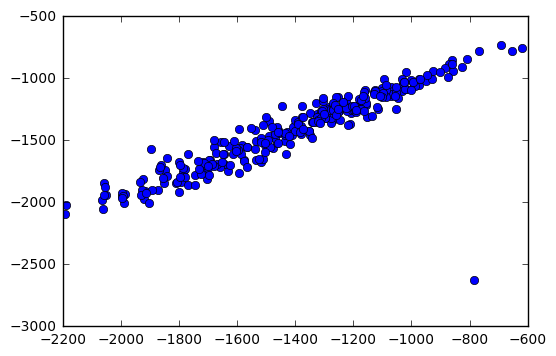

In [6]:
Epredict = numpy.dot(trainE,numpy.dot(kmatrix,numpy.transpose(Dmatrix)))

# compute the average error and show the regression plot
plt.plot(validE,Epredict,'o')
plt.show()